In [3]:
import forward_simulation
import numpy as np
import matplotlib.pyplot as plt

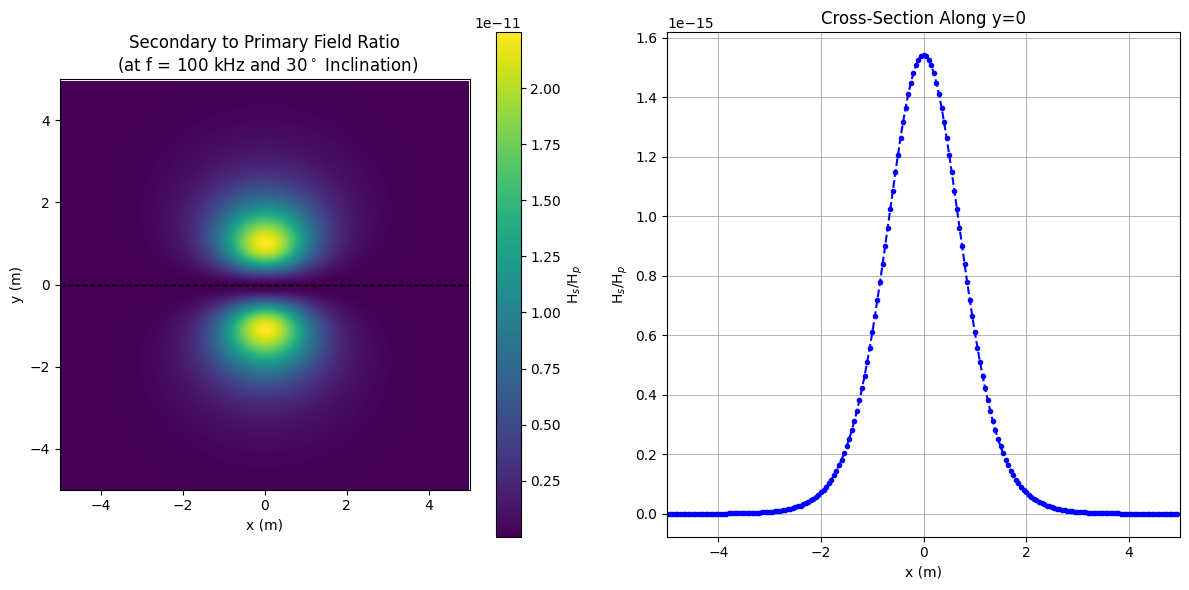

In [12]:
f = np.logspace(2,5,20)
dx = 0.05
xmin = -5
xmax = 5

response = forward_simulation.fem_pipe(
    sigma=1.0e6,
    mu=4*np.pi*10**(-7),
    xc=-0.0,
    yc=0.0,
    zc=2.0,
    dincl=0.0,
    ddecl=0.0,
    dipole_dist=1.0,
    sensor_ht=0.05,
    f=f,
    xmin=xmin,
    xmax=xmax,
    dx=dx,
    N_loops=1,
    length=0.01,
    rad=0.005,
)

xp = np.arange(xmin, xmax, dx)
yp = np.arange(xmin, xmax, dx)
real_response = np.real(response[:, :, -1])
imag_response = np.imag(response[:, :, -1])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

kx = int(np.ceil(xp.size / 2.0))
ax[1].plot(yp[:], imag_response[kx, :], ".--b")
ax[1].set_xlabel("x (m)")
ax[1].set_ylabel("H$_s$/H$_p$")
ax[1].set_title("Cross-Section Along y=0")
ax[1].grid(which="major", color="0.6", linestyle="-", linewidth="0.5")
ax[1].grid(which="minor", color="0.6", linestyle="-", linewidth="0.5")
ax[1].set_xlim(np.r_[xmin, xmax])

vminI = imag_response.min()
vmaxI = imag_response.max()
ax[0].plot(np.r_[xp.min(), xp.max()], np.zeros(2), "k--", lw=1)
clb = plt.colorbar(
    ax[0].imshow(
        imag_response,
        extent=[xp.min(), xp.max(), yp.min(), yp.max()],
        vmin=vminI,
        vmax=vmaxI,
    ),
    ax=ax[0],
)
ax[0].set_xlim(np.r_[xmin, xmax])
ax[0].set_ylim(np.r_[xmin, xmax])
ax[0].set_xlabel("x (m)")
ax[0].set_ylabel("y (m)")
ax[0].set_title("Secondary to Primary Field Ratio\n (at f = 100 kHz and 30$^\circ$ Inclination)")
clb.set_label("H$_s$/H$_p$")

plt.tight_layout()
plt.show()

Generate rebar

In [13]:
# number of samples
n_sims = 10

# survey space
x_min = -4 # m
x_max = 4 # m
dx = 0.05 # m
freqs = np.logspace(3, 5, 8) # Hz

# mechanical constants
dipole_dist = 0.9 # spacing between coils (m)
sensor_ht = 0.05 # height of the sensor above ground (m)

# random parameters
conductivity = np.random.uniform(1e5, 1e6, n_sims)
permeability = 4*np.pi*1e-7 # free space permeability
xc = np.random.uniform(x_min, x_max, n_sims)
yc = np.random.uniform(x_min, x_max, n_sims)
zc = np.random.uniform(0.5, 3, n_sims)
dincl = 0
ddecl = np.random.uniform(0, 360, n_sims) # declination angle in degrees
length = 30
rad = np.random.uniform(0.005, 0.02, n_sims)

# precision of simulation
n_loops = 200

response_list = []
for i in range(n_sims):
    # run simulation for each set of parameters
    response = forward_simulation.fem_pipe(
        conductivity[i],
        permeability,
        xc[i],
        yc[i],
        zc[i],
        dincl,
        ddecl[i],
        dipole_dist,
        sensor_ht,
        freqs,
        x_min,
        x_max,
        dx,
        n_loops,
        length,
        rad[i]
    )
    response_list.append(response)
    print(f"Simulation {i+1}/{n_sims} completed.")

Simulation 1/10 completed.
Simulation 2/10 completed.
Simulation 3/10 completed.
Simulation 4/10 completed.
Simulation 5/10 completed.
Simulation 6/10 completed.
Simulation 7/10 completed.
Simulation 8/10 completed.
Simulation 9/10 completed.
Simulation 10/10 completed.


In [15]:
response_list[0].shape

(160, 160, 8)

Simulate Random noise

In [41]:
def create_noise(n_sims:int):

    # survey space
    x_min = -4 # m
    x_max = 4 # m
    dx = 0.05 # m
    freqs = np.logspace(3, 5, 8) # Hz

    # mechanical constants
    dipole_dist = 0.9 # spacing between coils (m)
    sensor_ht = 0.05 # height of the sensor above ground (m)

    # random parameters
    conductivity = np.random.uniform(1e1, 1e3, n_sims)
    permeability = 4*np.pi*1e-7 # free space permeability
    xc = np.random.uniform(x_min, x_max, n_sims)
    yc = np.random.uniform(x_min, x_max, n_sims)
    zc = np.random.uniform(0.2, 3, n_sims)
    dincl = np.random.uniform(0, 90, n_sims) # inclination angle in degrees
    ddecl = np.random.uniform(0, 360, n_sims) # declination angle in degrees
    length = np.random.uniform(0.001, 0.01, n_sims) # length of the dipole (m)
    rad = np.random.uniform(0.05, 1, n_sims) * length

    # precision of simulation
    n_loops = np.random.randint(1, 5, n_sims)

    total_response = np.zeros((len(np.arange(x_min, x_max, dx)), len(np.arange(x_min, x_max, dx)), len(freqs)), dtype=complex)
    for i in range(n_sims):
        # run simulation for each set of parameters
        response = forward_simulation.fem_pipe(
            conductivity[i],
            permeability,
            xc[i],
            yc[i],
            zc[i],
            dincl[i],
            ddecl[i],
            dipole_dist,
            sensor_ht,
            freqs,
            x_min,
            x_max,
            dx,
            n_loops[i],
            length[i],
            rad[i]
        )
        total_response += response
    return total_response

n_datasets = 10
response_list = []
for i in range(n_datasets):
    n_sims = np.random.randint(100, 200)
    response = create_noise(n_sims)
    response_list.append(response)
    print(f"Simulation {i+1}/{n_datasets} completed.")

Simulation 1/10 completed.
Simulation 2/10 completed.
Simulation 3/10 completed.
Simulation 4/10 completed.
Simulation 5/10 completed.
Simulation 6/10 completed.
Simulation 7/10 completed.
Simulation 8/10 completed.
Simulation 9/10 completed.
Simulation 10/10 completed.


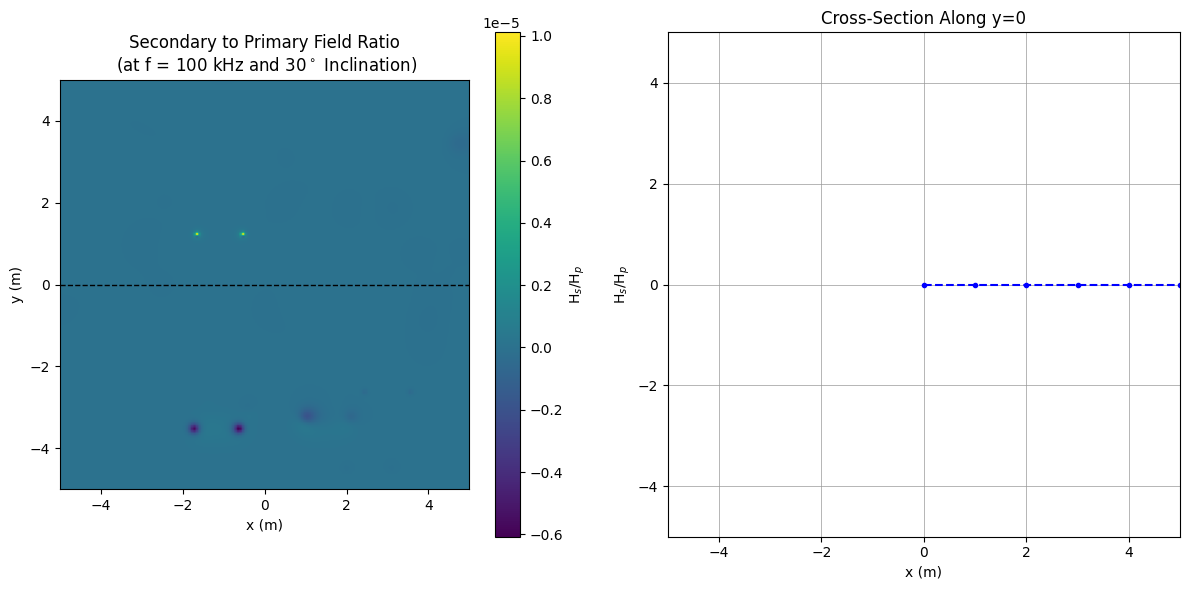

In [43]:
res = np.imag(response_list[3])

# plot the response
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

kx = int(np.ceil(res.shape[0] / 2.0))
ax[1].plot(np.arange(res.shape[1]), np.imag(res[kx, :, -1]), ".--b")
ax[1].set_xlabel("x (m)")
ax[1].set_ylabel("H$_s$/H$_p$")
ax[1].set_title("Cross-Section Along y=0")
ax[1].grid(which="major", color="0.6", linestyle="-", linewidth="0.5")
ax[1].grid(which="minor", color="0.6", linestyle="-", linewidth="0.5")
ax[1].set_xlim(np.r_[xmin, xmax])
ax[1].set_ylim(np.r_[xmin, xmax])

vminI = res.min()
vmaxI = res.max()
ax[0].plot(np.r_[xmin, xmax], np.zeros(2), "k--", lw=1)
clb = plt.colorbar(
    ax[0].imshow(
        res[:, :, -1],
        extent=[xmin, xmax, xmin, xmax],
        vmin=vminI,
        vmax=vmaxI,
    ),
    ax=ax[0],
)
ax[0].set_xlim(np.r_[xmin, xmax])
ax[0].set_ylim(np.r_[xmin, xmax])
ax[0].set_xlabel("x (m)")
ax[0].set_ylabel("y (m)")
ax[0].set_title("Secondary to Primary Field Ratio\n (at f = 100 kHz and 30$^\circ$ Inclination)")
clb.set_label("H$_s$/H$_p$")

plt.tight_layout()
plt.show()